## Loading packages

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

import scipy.sparse as sp
import warnings
import os

warnings.filterwarnings("ignore")

os.environ["R_HOME"] = "/home/lxx/.conda/envs/r4Base/lib/R"
os.environ["R_USER"] = "/home/lxx/.local/lib/python3.9/site-packages/rpy2"

import spCLUE

spCLUE.fix_seed(0)

In [2]:
sample_name = "stereoSeq_mob"
data_file = f"../dataset/STEREOSEQ/{sample_name}.h5ad"
adata = sc.read_h5ad(data_file)
adata.var_names_make_unique()
print(adata)

AnnData object with n_obs × n_vars = 19527 × 27106
    obs: 'array_row', 'array_col', 'used_barcodes'
    obsm: 'spatial'


## Preprocessing and constructing

In [3]:
adata = adata[adata.obs["used_barcodes"]].copy()
sc.pp.filter_genes(adata, min_cells=50)
adata = spCLUE.preprocess(adata)
adata.obsm["X_pca"] = PCA(n_components=200, random_state=0).fit_transform(adata.X)

## construct spatial graph and expr graph
g_spatial = spCLUE.prepare_graph(adata, "spatial")
g_expr = spCLUE.prepare_graph(adata, "expr")
graph_dict = {"spatial": g_spatial, "expr": g_expr}

normalized data ---------------->
create adjacent matrix from spatial idx --------------->
create knn graph ---->
spatial knn graph created ----<
create adjacent matrix from pca expr --------------->
create knn graph ---->
expr knn graph created ----<


## Training of spCLUE

In [4]:
spCLUE_model = spCLUE.spCLUE(adata.obsm["X_pca"], graph_dict) 

In [5]:
_, adata.obsm["spCLUE"] = spCLUE_model.train()

Training Start =========================>


 20%|██        | 101/500 [00:20<01:15,  5.29it/s]

epoch 100: 0.5690687981172612


 40%|████      | 201/500 [00:40<00:59,  5.01it/s]

epoch 200: 0.40922772843416444


 60%|██████    | 300/500 [00:59<00:37,  5.37it/s]

epoch 300: 0.23250506578815267


 80%|████████  | 401/500 [01:19<00:20,  4.83it/s]

epoch 400: 0.226199050254517


100%|██████████| 500/500 [01:38<00:00,  5.05it/s]


epoch 500: 0.23026145334692089
Training Finished =================<


## Clustering

In [6]:
cluster_method = "mclust"

label1 = spCLUE.clustering(
    adata,
    key="spCLUE",
    cluster_methods=cluster_method,
)

R[write to console]: Package 'mclust' version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



## Visualization

In [7]:
adata.obs["mclust"] = adata.obs["mclust"].astype("category")
adata.obsm["spatial"] = adata.obsm["spatial"][:, [1, 0]]

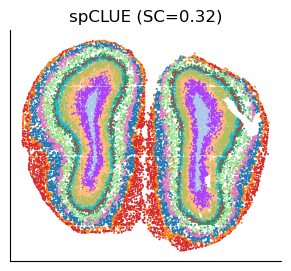

In [8]:
from sklearn.metrics import silhouette_score


fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
sc.pl.embedding(adata, basis="spatial", color="mclust", ax=ax, show=False, s=8)
legend_spCLUE = ax.get_legend_handles_labels()  # [handles, labels]
ax.legend([], frameon=False)

sc1 = silhouette_score(adata.obsm["spCLUE"], adata.obs["mclust"])
sc_score = np.round(sc1, 2)
ax.set_title("spCLUE (SC=%.2f)" % (sc_score,))
ax.set_xlabel("")
ax.set_ylabel("")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)